In [126]:
import numpy as np
import pandas as pd
import opendatasets as od
import os
import calendar
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [2]:
#od.download('https://www.kaggle.com/amandam1/breastcancerdataset')
#data set from kaggle 

In [3]:
curr  = os.getcwd()

In [4]:
os.chdir(curr + '\\' + 'breastcancerdataset')

In [5]:
files = os.listdir()
file = files[0]

In [6]:
def file_open(path):
    
    with open(path) as f_obj:
        content = pd.read_csv(f_obj)
    return content

In [7]:
data_uncleaned= file_open(file)
#retrieves files from dir as a pandas dataframe

In [8]:
data_uncleaned.head()

,ï»¿Patient_ID,Age,Gender,Protein1,Protein2,Protein3,Protein4,Tumour_Stage,Histology,ER status,PR status,HER2 status,Surgery_type,Date_of_Surgery,Date_of_Last_Visit,Patient_Status
0,TCGA-D8-A1XD,36.0,FEMALE,0.080353,0.42638,0.54715,0.273680,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,15-Jan-17,19-Jun-17,Alive
1,TCGA-EW-A1OX,43.0,FEMALE,-0.420320,0.57807,0.61447,-0.031505,II,Mucinous Carcinoma,Positive,Positive,Negative,Lumpectomy,26-Apr-17,09-Nov-18,Dead
2,TCGA-A8-A079,69.0,FEMALE,0.213980,1.31140,-0.32747,-0.234260,III,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,08-Sep-17,09-Jun-18,Alive
3,TCGA-D8-A1XR,56.0,FEMALE,0.345090,-0.21147,-0.19304,0.124270,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Modified Radical Mastectomy,25-Jan-17,12-Jul-17,Alive
4,TCGA-BH-A0BF,56.0,FEMALE,0.221550,1.90680,0.52045,-0.311990,II,Infiltrating Ductal Carcinoma,Positive,Positive,Negative,Other,06-May-17,27-Jun-19,Dead


In [9]:
data_uncleaned = data_uncleaned.drop(columns = ['Gender'],axis = 0)
#all are female

In [10]:
def drop_NaN(df):
    idxs_to_drop = []
    for i in range(len(df)):
        if df.iloc[i].isnull().any() == True:
            idxs_to_drop.append(i)
            
    Y = df['Patient_Status']
    X = df.drop(columns=['Patient_Status'],axis = 0)
    
    useful_data = X.drop(idxs_to_drop,axis= 0)
    target = Y.drop(idxs_to_drop,axis=0)
    
    return useful_data,target

In [11]:
month_dict = {month: str(index) for index, month in enumerate(calendar.month_abbr) if month}

In [12]:
def date_corrected(date):
    
    date = date.split('-')
    month = date[1]
    year = date[2]
    year_complete = '20' + year
    
    month_complete = month_dict.get(month)
    
    date_complete = '/'.join((date[0],month_complete,year_complete))
    
    return date_complete

In [13]:
def add_days_btwn_visits(df):
    
    days_to_be_added_to_df = []
    date_format = "%d/%m/%Y"
   
    for i in range(len(df)):
        
        surgery  = df.iloc[i]['Date_of_Surgery']
        last = df.iloc[i]['Date_of_Last_Visit']
        
        surgery = date_corrected(surgery)
        last = date_corrected(last)
        
        surg_date = datetime.strptime(surgery, date_format)
        visit_date = datetime.strptime(last, date_format)
        
        days = visit_date - surg_date
        days_to_be_added_to_df.append(days)
    
    days_str = [str(x).split(" ")[0] for x in days_to_be_added_to_df]
    
    data_cleaned = []
    for day in days_str:
        if day == '0:00:00':
            day = '0'
        data_cleaned.append(day)
        
    days_int = [int(x) for x in data_cleaned] 
         
    df['Days_btwn_surg_and_last_visit'] = days_int
    return df
    

In [ ]:
"""The above functions are used to remove Nan values as well as take the dates between surgery and last visit and convert them
to the number of days in between """

In [14]:
data_no_visits,target = drop_NaN(data_uncleaned)

In [156]:
binary_target = (target == 'Alive')
#True if Alive , False if dead used for binary classification

In [157]:
data_with_visits= add_days_btwn_visits(data_no_visits)

In [158]:
roman_numeral_column = data_with_visits['Tumour_Stage'].apply(lambda x: len(x))
#converts roman numerals to arabic numerals

In [159]:
data_wo_unimportant_columns = data_with_visits.drop(columns = ['Date_of_Surgery','Date_of_Last_Visit','ï»¿Patient_ID',
                                                           'Tumour_Stage','PR status','ER status'],axis= 0)
data_wo_unimportant_columns.head()
#removes unimportant columns before training

,Age,Protein1,Protein2,Protein3,Protein4,Histology,HER2 status,Surgery_type,Days_btwn_surg_and_last_visit
0,36.0,0.080353,0.42638,0.54715,0.273680,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,155
1,43.0,-0.420320,0.57807,0.61447,-0.031505,Mucinous Carcinoma,Negative,Lumpectomy,562
2,69.0,0.213980,1.31140,-0.32747,-0.234260,Infiltrating Ductal Carcinoma,Negative,Other,274
3,56.0,0.345090,-0.21147,-0.19304,0.124270,Infiltrating Ductal Carcinoma,Negative,Modified Radical Mastectomy,168
4,56.0,0.221550,1.90680,0.52045,-0.311990,Infiltrating Ductal Carcinoma,Negative,Other,782


In [160]:
data_wo_unimportant_columns['Tumour_stage_int'] = roman_numeral_column

In [161]:
data = pd.get_dummies(data_wo_unimportant_columns,columns = ['Histology','HER2 status','Surgery_type'])
#these are one hot encoded to get binary columns so that data can be classified

In [162]:
data.head()

,Age,Protein1,Protein2,Protein3,Protein4,Days_btwn_surg_and_last_visit,Tumour_stage_int,Histology_Infiltrating Ductal Carcinoma,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,HER2 status_Negative,HER2 status_Positive,Surgery_type_Lumpectomy,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy
0,36.0,0.080353,0.42638,0.54715,0.273680,155,3,1,0,0,1,0,0,1,0,0
1,43.0,-0.420320,0.57807,0.61447,-0.031505,562,2,0,0,1,1,0,1,0,0,0
2,69.0,0.213980,1.31140,-0.32747,-0.234260,274,3,1,0,0,1,0,0,0,1,0
3,56.0,0.345090,-0.21147,-0.19304,0.124270,168,2,1,0,0,1,0,0,1,0,0
4,56.0,0.221550,1.90680,0.52045,-0.311990,782,2,1,0,0,1,0,0,0,1,0


In [163]:
x_train,x_test,y_train,y_test = train_test_split(data,binary_target,test_size = .2)

In [164]:
#here I used a PCA to try and maintain much of the variance
pca = PCA(n_components = .99999999)
x_reduced = pca.fit_transform(x_train)

In [165]:
pca.explained_variance_ratio_

array([9.98922299e-01, 1.05514197e-03, 6.23736359e-06, 2.75008380e-06,
       2.60630149e-06, 2.29213835e-06, 1.85580761e-06, 1.65107180e-06,
       1.38188962e-06, 1.29437334e-06, 1.28260009e-06, 9.03123552e-07,
       3.04347748e-07])

In [166]:
x_reduced
#reduced needs to be tested to see how it effects classification

array([[ 2.06630231e+02, -1.72038097e+01,  1.11219832e+00, ...,
        -2.05562768e-01,  1.42448243e-01, -4.41450632e-02],
       [-2.35389072e+02, -1.72212453e+00, -3.95286063e-01, ...,
         1.09155683e-01, -5.28773880e-01, -1.06562863e-01],
       [-1.81369606e+02, -1.76709786e+01, -1.43879124e+00, ...,
        -1.98480418e-01,  1.28826168e+00, -1.19592134e-01],
       ...,
       [-3.17384542e+02, -5.84000652e+00, -1.71896789e+00, ...,
         5.82890753e-01, -2.92014535e-01, -3.06855234e-02],
       [-5.63822961e+01, -7.52312972e+00,  1.79465448e-01, ...,
         3.84247293e-01,  8.24243423e-01,  3.37269319e-02],
       [ 5.74611706e+02, -1.72973258e+00,  7.85746374e-02, ...,
        -3.41329521e-01,  1.15940191e-01,  1.20485607e-02]])

In [167]:
x_train

,Age,Protein1,Protein2,Protein3,Protein4,Days_btwn_surg_and_last_visit,Tumour_stage_int,Histology_Infiltrating Ductal Carcinoma,Histology_Infiltrating Lobular Carcinoma,Histology_Mucinous Carcinoma,HER2 status_Negative,HER2 status_Positive,Surgery_type_Lumpectomy,Surgery_type_Modified Radical Mastectomy,Surgery_type_Other,Surgery_type_Simple Mastectomy
258,41.0,-0.059289,2.05520,0.047034,-0.210040,660,2,0,1,0,1,0,0,0,1,0
58,57.0,0.000000,0.20684,-0.161100,0.374030,218,1,1,0,0,1,0,1,0,0,0
98,41.0,0.100120,-0.46547,0.472370,-0.523870,272,1,1,0,0,0,1,0,1,0,0
205,47.0,-0.198190,0.62597,-0.281370,-0.477740,189,2,1,0,0,1,0,1,0,0,0
162,50.0,-0.158420,2.15150,-0.853600,0.543330,650,3,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,44.0,0.732720,1.11170,-0.269520,-0.354920,124,2,0,1,0,1,0,0,0,1,0
312,66.0,-1.344100,1.12800,-0.229350,-0.229930,496,2,1,0,0,1,0,0,0,1,0
103,53.0,0.014106,-0.68397,0.538150,0.718970,136,3,1,0,0,1,0,0,0,0,1
228,51.0,-0.384660,0.80609,-1.627400,-0.512910,397,2,1,0,0,0,1,0,1,0,0


In [168]:
sgd_clf = SGDClassifier()
sgd_clf.fit(x_train,y_train)

SGDClassifier()

In [169]:
y_test.iloc[0]
#look test

True

In [170]:
from_pandas = x_test.iloc[0]
data = np.array(from_pandas)
data_pt = data.reshape(1,-1)
data_pt

array([[ 4.9000e+01,  6.1643e-02,  1.3149e+00, -9.9357e-02,  7.5441e-01,
         1.7000e+02,  2.0000e+00,  0.0000e+00,  1.0000e+00,  0.0000e+00,
         1.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,
         0.0000e+00]])

In [171]:
sgd_clf.predict(data_pt)
#obviously not passing the look test 

array([ True])

In [172]:
sgd_clf_re = SGDClassifier()
sgd_clf_re.fit(x_reduced,y_train)

SGDClassifier()

In [173]:
sgd_clf.predict(data_pt)
#does not work either 

array([ True])

In [174]:
score = cross_val_score(sgd_clf,x_train,y_train,cv=3,scoring='accuracy')
score
#not too bad

array([0.81176471, 0.75      , 0.80952381])

In [175]:
score_reduced = cross_val_score(sgd_clf,x_reduced,y_train,cv=3,scoring='accuracy')
score_reduced
#x reduced is not much better maybe it is best to keep all features

array([0.54117647, 0.53571429, 0.52380952])

In [176]:
y_train_pred =  cross_val_predict(sgd_clf,x_train,y_train,cv=3)

In [177]:
confusion_matrix(y_train,y_train_pred)
#good at classifying if someone is alive but bad at classifying if someone died
#low cv will show bad classifiication 

array([[ 17,  31],
       [ 77, 128]], dtype=int64)

In [178]:
#lets see if correcting the decision function helps makes a better model

In [179]:
precision_score(y_train,y_train_pred)

0.8050314465408805

In [180]:
recall_score(y_train,y_train_pred)
#all of the pts become alive at a certain pt

0.624390243902439

In [87]:
def plot_precision_recall_and_threshold(precisions,recalls,thresholds):
    plt.plot(thresholds,precisions[:-1],'b--',label='Precision')
    plt.plot(thresholds,recalls[:-1],'g-',label='Recall')

In [88]:
y_scores = cross_val_predict(sgd_clf,x_train,y_train,cv=3,method='decision_function')

In [89]:
precisions,recalls,thresholds = precision_recall_curve(y_train,y_scores)

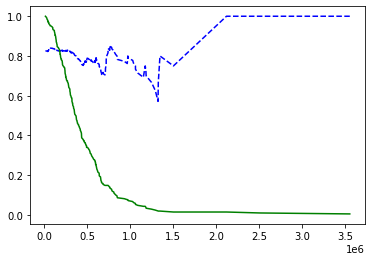

In [90]:
plot_precision_recall_and_threshold(precisions,recalls,thresholds)
plt.show()

In [109]:
theshold_80_precision = thresholds[np.argmax(precisions == 0.90)]
y_train_pred_80 = (y_scores >= theshold_80_precision )

In [110]:
precision_score(y_train,y_train_pred_80)

0.8260869565217391

In [111]:
recall_score(y_train,y_train_pred_80)

1.0

In [112]:
confusion_matrix(y_train,y_train_pred_80)
#the best model is one that incorrectly classifies deaths but correctly classifies alive
#i think this measn it is oveerfitting everything

array([[  0,  44],
       [  0, 209]], dtype=int64)

In [83]:
fpr,tnr,thresholds = roc_curve(y_train,y_scores)

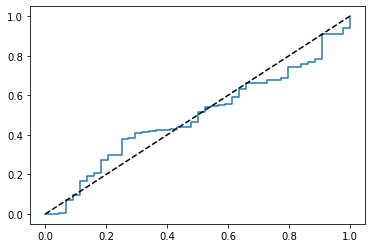

In [84]:
def plot_roc_curve(fpr,tnr,label=None):
    plt.plot(fpr,tnr,label=label)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr,tnr)
plt.show()

In [113]:
roc_auc_score(y_train,y_scores)
#so althoguh the model is good at detecting true positives it is bad at determining true negatives

0.4512831665941714

In [114]:
"""SGD classifier is not bad but there may possibly be a better classifier to do the job
the goal for all classifiers from here should be to more accurately predict deaths"""

'SGD classifier is not bad but there may possibly be a better classifier to do the job\nthe goal for all classifiers from here should be to more accurately predict deaths'

In [115]:
svc_pipe = Pipeline([('std',StandardScaler()),
                    ('svc',SVC())])
svc_pipe.fit(x_train,y_train)

Pipeline(steps=[('std', StandardScaler()), ('svc', SVC())])

In [116]:
svc_pipe.predict(data_pt)

array([ True])

In [117]:
score_reduced_svc = cross_val_score(svc_pipe,x_train,y_train,cv=3,scoring='accuracy')
score_reduced_svc
#ac

array([0.82352941, 0.83333333, 0.82142857])

In [118]:
def test_svc_kernels(kernel_names):
    for kernel_name in kernel_names:
        svc_pipeline = Pipeline([('std',StandardScaler()),
                            ('svc',SVC(kernel= kernel_name))])
        svc_pipeline.fit(x_train,y_train)
        score = cross_val_score(svc_pipeline,x_train,y_train,cv=3,scoring='accuracy')
        print(kernel_name,": ",score)       

In [119]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
test_svc_kernels(kernels)
#doesn't change much

linear :  [0.82352941 0.83333333 0.82142857]
poly :  [0.82352941 0.83333333 0.78571429]
rbf :  [0.82352941 0.83333333 0.82142857]
sigmoid :  [0.84705882 0.83333333 0.82142857]


In [120]:
rnd_clf  = RandomForestClassifier(n_estimators = 1000)
rnd_clf.fit(x_train,y_train)

RandomForestClassifier(n_estimators=1000)

In [121]:
scores_probs = cross_val_predict(rnd_clf,x_train,y_train,cv=3,method='predict_proba')

In [122]:
forest_scores = scores_probs[:,1]

In [123]:
roc_auc_score(y_train,forest_scores)

0.48901696389734667

In [58]:
params = [{'n_estimators':[100,1000,1500,2000,10000],'max_features':[2,4,6,8]}]

In [59]:
test_rnd_clf = RandomForestClassifier()
grid_search = GridSearchCV(test_rnd_clf,params,cv=5,scoring='accuracy')

In [60]:
grid_search.fit(x_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [100, 1000, 1500, 2000, 10000]}],
             scoring='accuracy')

In [61]:
grid_search.best_params_

{'max_features': 2, 'n_estimators': 100}

In [62]:
best_feat_clf = RandomForestClassifier(max_features=  2, n_estimators = 100)
best_feat_clf.fit(x_train,y_train)

RandomForestClassifier(max_features=2)

In [63]:
scores_probs = cross_val_predict(best_feat_clf,x_train,y_train,cv=3,method='predict_proba')
forest_scores = scores_probs[:,1]
roc_auc_score(y_train,forest_scores)
#not any better 

0.4960852544584602

In [64]:
rnd_clf2 = RandomForestClassifier(max_features = 2)
sgd_clf = SGDClassifier()
svc_pipe = Pipeline([('std',StandardScaler()),
                    ('svc',SVC())])

In [65]:
voting_clf = VotingClassifier(estimators = [('svc',svc_pipe),('sgd',sgd_clf)],voting = 'hard')

In [66]:
voting_clf.fit(x_train,y_train)

VotingClassifier(estimators=[('svc',
                              Pipeline(steps=[('std', StandardScaler()),
                                              ('svc', SVC())])),
                             ('sgd', SGDClassifier())])

In [67]:
y_pred_vote = voting_clf.predict(x_test)

In [128]:
accuracy_score(y_test,y_pred_vote)

0.71875

In [130]:
confusion_matrix(y_test,y_pred_vote)
#same deal

array([[ 0, 18],
       [ 0, 46]], dtype=int64)

In [133]:
#when testing for death the model still overfits for alive
#i think overall there is either not enough data or no data that could correlate with death